In [3]:
! pip install  git+https://github.com/arn-all/neighbors-maps

  Cloning https://github.com/arn-all/neighbors-maps to /tmp/pip-req-build-j8oyeph3
  Running command git clone --filter=blob:none --quiet https://github.com/arn-all/neighbors-maps /tmp/pip-req-build-j8oyeph3
  Resolved https://github.com/arn-all/neighbors-maps to commit 6b1181d4e84c70049cd7136f8693eb76fcd620fd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


# 1. Create synthetic data

We will use ASE to generate a dataset of simple crystal structures

In [321]:
# coding: utf-8
import ase.lattice
import ase.lattice.tetragonal
import ase.lattice.monoclinic
import ase.lattice.triclinic
import ase.lattice.cubic
import ase.lattice.hexagonal
import ase.lattice.orthorhombic
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm

import ase
from neighbors_map import Atoms
%matplotlib inline

def get_cutoff(atoms, n_neightbours, cutoff=10.):
    """
    Function to get the distance of n_th neighbour using matscipy neighbour list.
    """
    from matscipy.neighbours import neighbour_list

    i, d = neighbour_list("id", atoms, cutoff=cutoff)
    first_atom_d = d[i == 0]
    first_atom_d.sort()
    return first_atom_d[n_neightbours]


# List of Bravais lattices with lattice constants
bravais_lattices = [
    ("cubic", "SimpleCubic", 3.0),
    ("cubic", "FaceCenteredCubic", 3.0),
    ("cubic", "BodyCenteredCubic", 3.0),
    ("cubic", "Diamond", 3.0),
    ("orthorhombic", "BaseCenteredOrthorhombic", {'a': 3.0, 'b/a': 1.2, 'c/a': 1.8}),
    ("orthorhombic", "FaceCenteredOrthorhombic", {'a': 3.0, 'b/a': 1.2, 'c/a': 1.8}),
    ("orthorhombic", "BodyCenteredOrthorhombic", {'a': 3.0, 'b/a': 1.2, 'c/a': 1.8}),
]

# Function to generate the descriptor for a given lattice type
def generate_lat(lattice_module, lattice_class, element, size, lattice_constants):
    lattice = getattr(getattr(ase.lattice, lattice_module), lattice_class)(element, size=size, latticeconstant=lattice_constants)
    return Atoms(lattice)

lattices = []
lattice_num = []
lattice_name = []
for i, (lattice_type, lattice_class, lattice_constants) in enumerate(bravais_lattices):
    lattices.append(generate_lat(lattice_type, lattice_class, "Fe", (6,6,6), lattice_constants))
    lattice_num.append(i)
    lattice_name.append(lattice_class)

Here is what we created:

In [338]:
lattices, lattice_num, lattice_name

([Atoms(symbols='Fe64', pbc=True, cell=[12.0, 12.0, 12.0]),
  Atoms(symbols='Fe256', pbc=True, cell=[12.0, 12.0, 12.0]),
  Atoms(symbols='Fe128', pbc=True, cell=[12.0, 12.0, 12.0]),
  Atoms(symbols='Fe512', pbc=True, cell=[12.0, 12.0, 12.0]),
  Atoms(symbols='Fe128', pbc=True, cell=[12.0, 14.399999999999999, 21.6]),
  Atoms(symbols='Fe256', pbc=True, cell=[12.0, 14.399999999999999, 21.6]),
  Atoms(symbols='Fe128', pbc=True, cell=[12.0, 14.399999999999999, 21.6])],
 [0, 1, 2, 3, 4, 5, 6],
 ['SimpleCubic',
  'FaceCenteredCubic',
  'BodyCenteredCubic',
  'Diamond',
  'BaseCenteredOrthorhombic',
  'FaceCenteredOrthorhombic',
  'BodyCenteredOrthorhombic'])

# 2. On the choice of a cut-off radius 

- The cut-off radius is a critical parameter as it controls the locality assumption that is made when we talk about a *local* atomic environment
- Some processes or transformations will be much easier to detect with a longer cut-off radius, while increased computational cost and signal averaging are more likely for long cut-offs 

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


Text(0, 0.5, 'Number of neighbors')

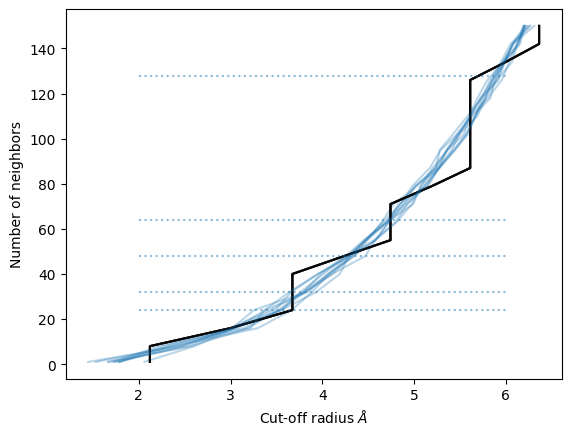

In [339]:
# Define an array of values for the number of 
# neighbors that should exist within the rcut
n_neighbors = [24, 32, 48, 64, 128]

X = np.linspace(1, 150, 20, dtype=int)

for i in tqdm(range(10)):
    atoms = lattices[1].copy()
    plt.plot([get_cutoff(atoms, x) for x in X], X, "-", color='k', alpha=0.3)
    atoms.rattle(stdev=0.3, seed=i)
    plt.plot([get_cutoff(atoms, x) for x in X], X, "-", color='C0', alpha=0.3)
    
plt.hlines(n_neighbors, xmin=2, xmax=6, linestyle=":", alpha=0.5, label="")

# plt.legend(frameon=False)
plt.xlabel(r"Cut-off radius $\AA$")
plt.ylabel("Number of neighbors")

NB: In crystals, the number of atoms within a cut-off radius is not a smooth or linear function.
Above, we show the number of neighbors found within a certain cut-off radius, for a perfect fcc crystal (black) and for the same crystal with a Gaussian noise applied on atomic positions

## 3. Effect of the cut-off radius on atomic descriptors

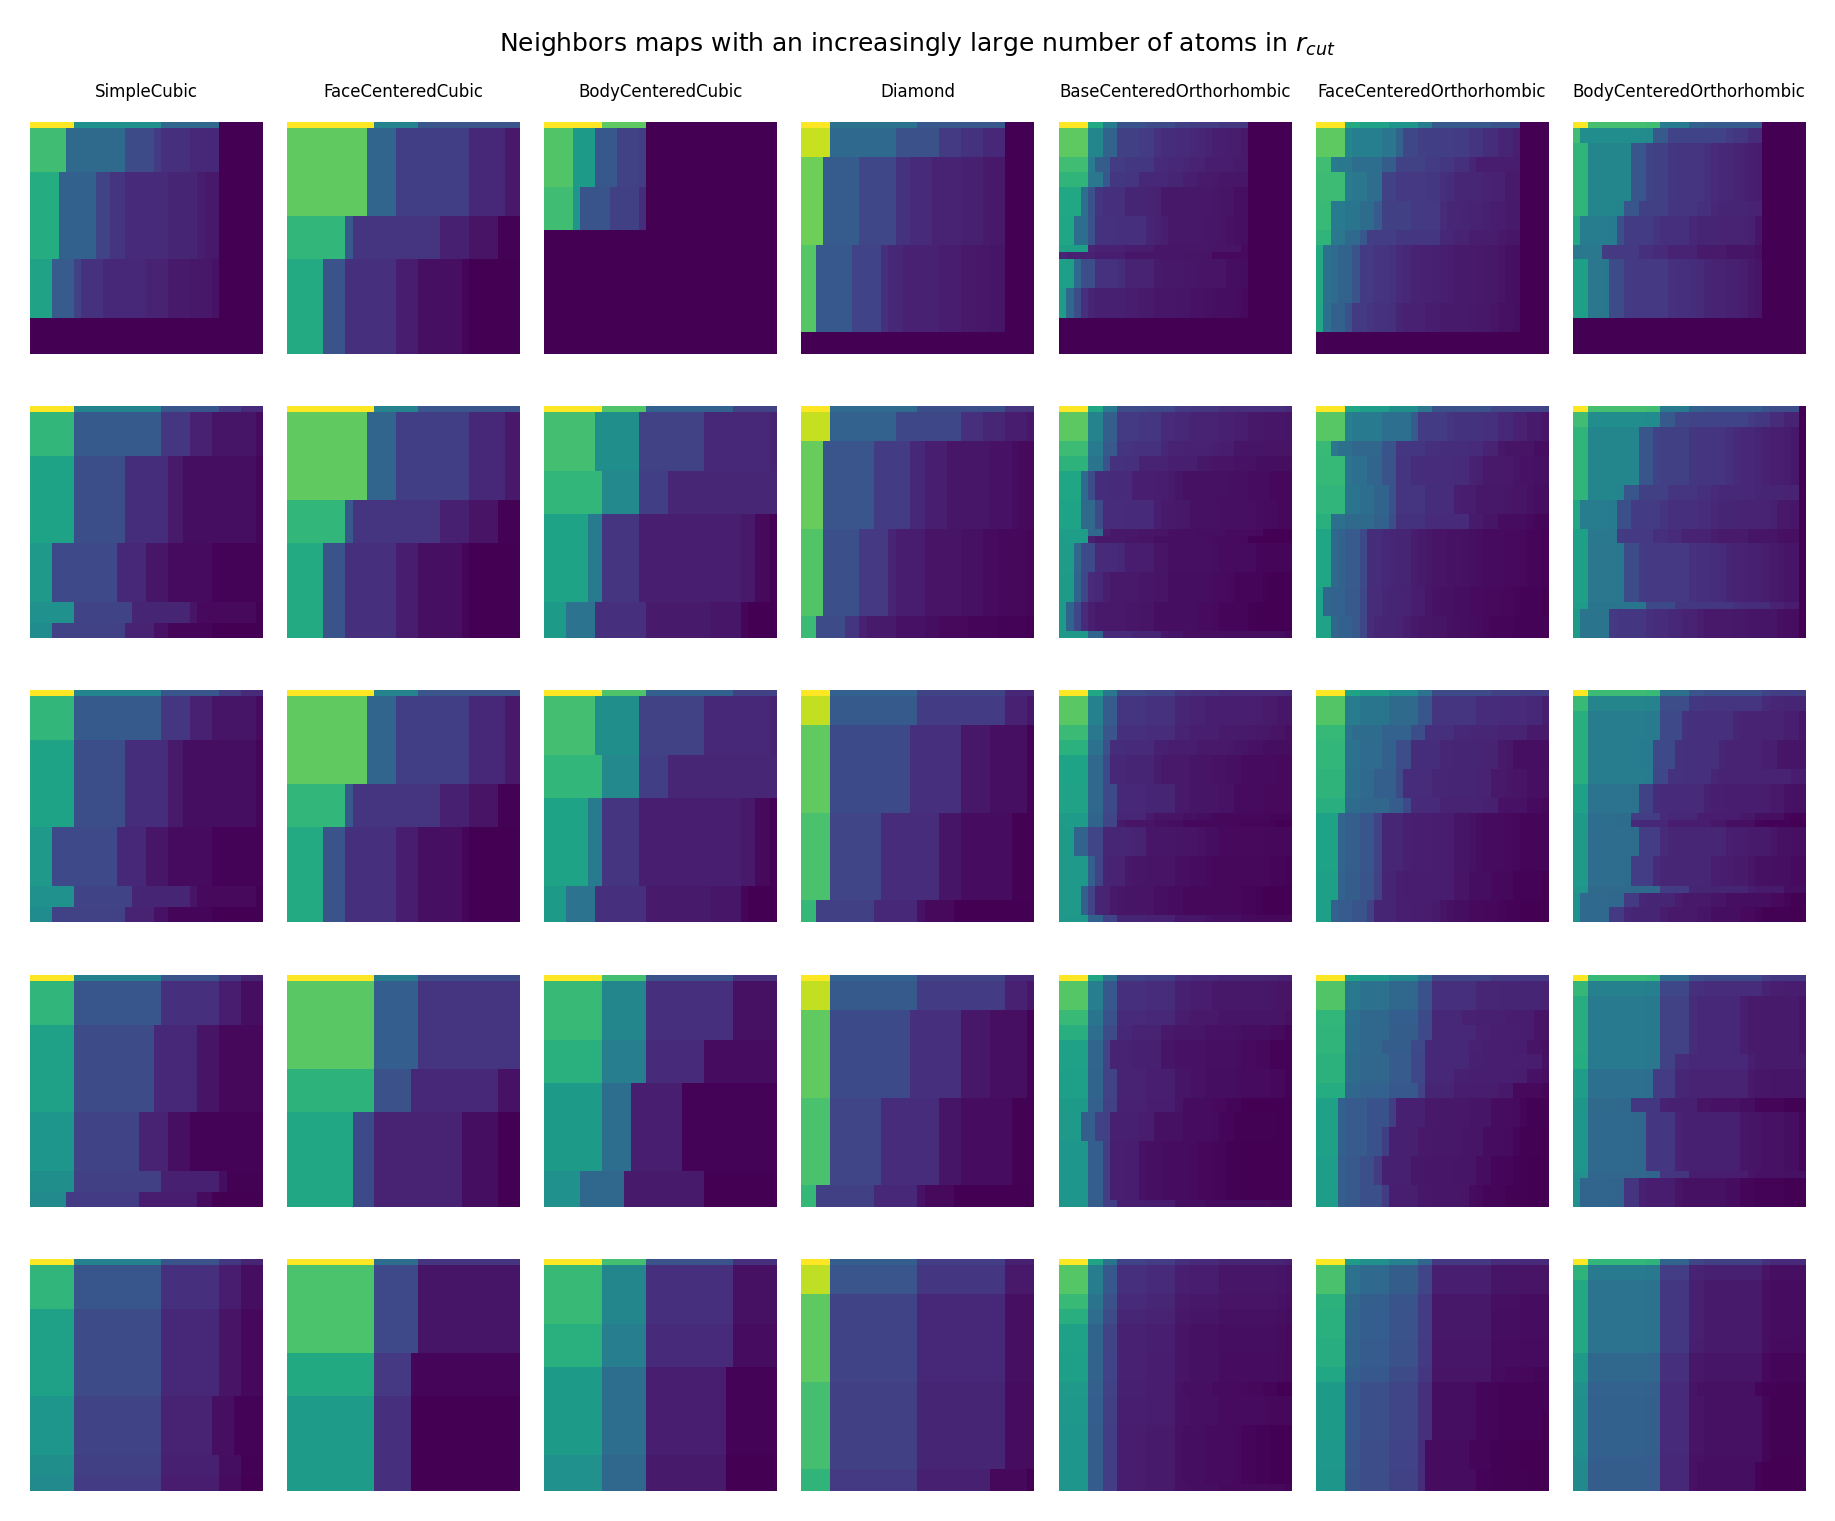

In [340]:
def plot_nm(ax, number_of_neighbors_in_rcut=32):
    
    for i, (lattice, bravais) in enumerate(zip(lattices, bravais_lattices)):
        plt.sca(ax[i])
        lat = Atoms(lattice)

        # What is the effect of the row and line decay ?
        # lat.neighbor_map.beta = 2
        # lat.neighbor_map.gamma = 2
        
        image = lat.get_neighbor_map(0, r_cut=get_cutoff(lat, 
                                                         number_of_neighbors_in_rcut))
        plt.imshow(image)
        plt.axis("off")
        

fig, axs = plt.subplots(5, len(lattices), figsize=(6,5), dpi=300, constrained_layout=True)


# show images with different rcuts
for i, n in enumerate(n_neighbors):
    plot_nm(ax=axs[i], number_of_neighbors_in_rcut=n)

# add columns titles
for i, _ in enumerate(lattices):
    axs[0, i].set_title(bravais_lattices[i][1], fontsize=4)


plt.suptitle(r"Neighbors maps with an increasingly large number of atoms in $r_{cut}$", size=6)
plt.show()

- Visually, do the images above (for a given row) seem different enough to be classified ?

**Images stongly depend on the cut-off radius -> comparison should be done for a given rcut and values of beta and gamma**

## 4. Effect of uncorrelated noise on neighbors maps 

- How is the structure of neighbors maps affected by noise ?

In [341]:
def noisy_structure(atoms, noise):
    noisy_atoms = atoms.copy()
    noisy_atoms.positions += np.random.normal(loc=0, scale=noise, size=(atoms.positions.shape[0], 3))
    return Atoms(noisy_atoms)

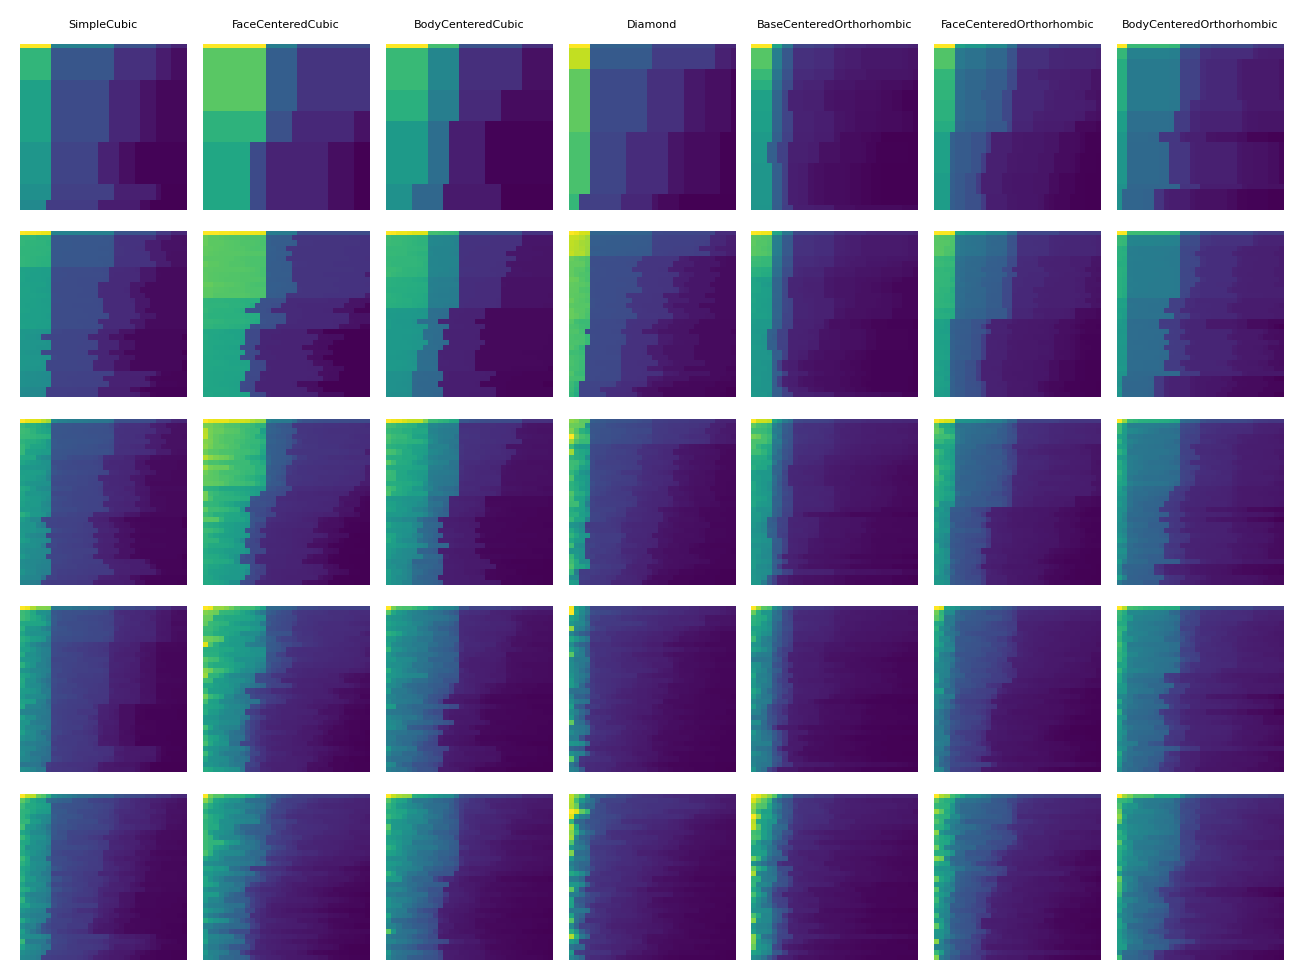

In [342]:

number_of_neighbors_in_rcut = 64
noise_levels = [0, 0.01, 0.05, 0.1, 0.15]

fig, ax = plt.subplots(len(noise_levels), len(lattices), constrained_layout=True, dpi=200)

for i, noise_level in enumerate(noise_levels):
    for j, lattice in enumerate(lattices):
        ax[i,j].imshow(noisy_structure(lattice, noise_level).get_neighbor_map(0, r_cut=get_cutoff(lattice, 
                                                                                                  number_of_neighbors_in_rcut)))
        ax[i,j].axis("off")

# add columns titles
for i, _ in enumerate(lattices):
    ax[0, i].set_title(bravais_lattices[i][1], fontsize=4)

## 5. Getting ready for classification

- Are the images above different enough to be classified ?
- To answer, we will try to find a low-dimension representation of the images that allows to discriminate them.
- We will use the PCA and LDA methods.
- We will try different cut-off radii, with different levels of noise, on different structures, so this will take approximately a minute (code is not optimized here)

In [525]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import matplotlib as mpl

# for a zoomable version (recommended)
%matplotlib tk

# to get back to notebook plot
# %matplotlib inline 

noise_levels = [0.1, 0.15, 0.2, 0.3]


def plot_pca(number_of_neighbors_in_rcut, beta=3, gamma=2, img_size=32):
    fig, axes = plt.subplots(2, len(noise_levels), figsize=(10, 4), dpi=200, constrained_layout=True)
    
    for i_noise, noise_level in enumerate(tqdm(noise_levels)):
    
    
        all_images = []
        lattice_name_ = []
        lattice_num_ = []
        for i, (lattice, lat_num, lat_name) in enumerate(zip(lattices, lattice_num, lattice_name)):    
            structure = noisy_structure(lattice, noise_level)
            
            # What is the effect of the row and line decay ?
            structure.neighbor_map.beta = beta
            structure.neighbor_map.gamma = gamma
            for at in np.random.choice(len(lattice), 50):
                image = structure.get_neighbor_map(at, r_cut=get_cutoff(lattice, number_of_neighbors_in_rcut), img_target_size=img_size).flatten()
                all_images.append(image)
                lattice_num_.append(lat_num)
                lattice_name_.append(lat_name)
        
        all_images = np.array(all_images)
        
        model1 = PCA(n_components=2)
        model2 = LinearDiscriminantAnalysis(n_components=2)

        for model_i, m in enumerate([model1, model2]): 
            # The two models have different signatures
            if model_i==0:
                model_result = m.fit_transform(all_images)
            else:
                model_result = m.fit_transform(all_images, lattice_num_)
        
            axes[model_i, i_noise].scatter(model_result[:, 0], model_result[:, 1], color=mpl.cm.tab10(lattice_num_), s=2, alpha=0.8)
            axes[model_i, i_noise].set_title(f"{["PCA", "LDA"][model_i]} Noise std: {noise_level:.2f}")
            
    plt.savefig(f"pca_{number_of_neighbors_in_rcut}.pdf") # change to let beta and gamma vary
    plt.show()

# What level of noise can you reach while keeping a nice clusters separation ?


for n_neigh in [32, 64, 128]:
    print(f"{n_neigh} Neighbors")
    plot_pca(number_of_neighbors_in_rcut=n_neigh, 
             img_size=32)

32 Neighbors


100%|█████████████████████████████████████████████| 4/4 [00:48<00:00, 12.10s/it]


64 Neighbors


100%|█████████████████████████████████████████████| 4/4 [00:52<00:00, 13.01s/it]


128 Neighbors


100%|█████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]


- Which method seems the most efficient for separating clusters ? Does it always work ?
- What is the unit or meaning of the plots axis ? 
- How could we improve the results ?
- Can you make the separation better for high noise conditions ?
- Is the uncorrelated noise used here representative of thermal noise ?
- Do all clusters have approx. the same variance ?
- What is the effect of the cut-off radius ?

## 6. Clustering methods

For the following, let's pick the condition "64 Neighbors / noise_std = 0.15A", where PCA performs well.

Now, we will try to cluster the data in an unsupervised or supervised way

In [482]:
lattice_name_ = []
lattice_num_ = []
all_images = []

for i, (lattice, lat_num, lat_name) in enumerate(zip(lattices, lattice_num, lattice_name)):
    structure = noisy_structure(lattice, 0.15)
    for at in np.random.choice(len(lattice), 140):
        image = structure.get_neighbor_map(at, r_cut=get_cutoff(lattice, 64), img_target_size=32).flatten()
        all_images.append(image)
        lattice_num_.append(lat_num)
        lattice_name_.append(lat_name)
all_images = np.array(all_images)

Unsupervised methods

In [526]:
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.manifold import TSNE

model_lowd = PCA(n_components=2)
low_dimension_imgs = model_lowd.fit_transform(all_images)

# Try this ?
low_dimension_imgs = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40).fit_transform(all_images)

gm = GaussianMixture(n_components=7)
gm.fit(low_dimension_imgs)

data_classes_gmm = gm.predict(low_dimension_imgs)

fig, axes = plt.subplots(figsize=(4, 4), dpi=144, constrained_layout=True)

plt.scatter(low_dimension_imgs[:, 0], 
            low_dimension_imgs[:, 1], 
            color=mpl.cm.tab10(data_classes_gmm), 
            s=2, alpha=0.8)


from sklearn.metrics import adjusted_rand_score
# A metric of unsupervised clustering methods performance is the Adjusted Rand Index 
# (1: perfect agreement with ground truth, 0: equivalent to random assignment)
ari = adjusted_rand_score(lattice_num_, data_classes_gmm)
print("ARI:", ari)


ARI: 1.0


- How does the method perform when the perplexity parameter varies ?
- Can we do just as good with other unsupervised clustering methods such as KMeans or DBSCAN ?

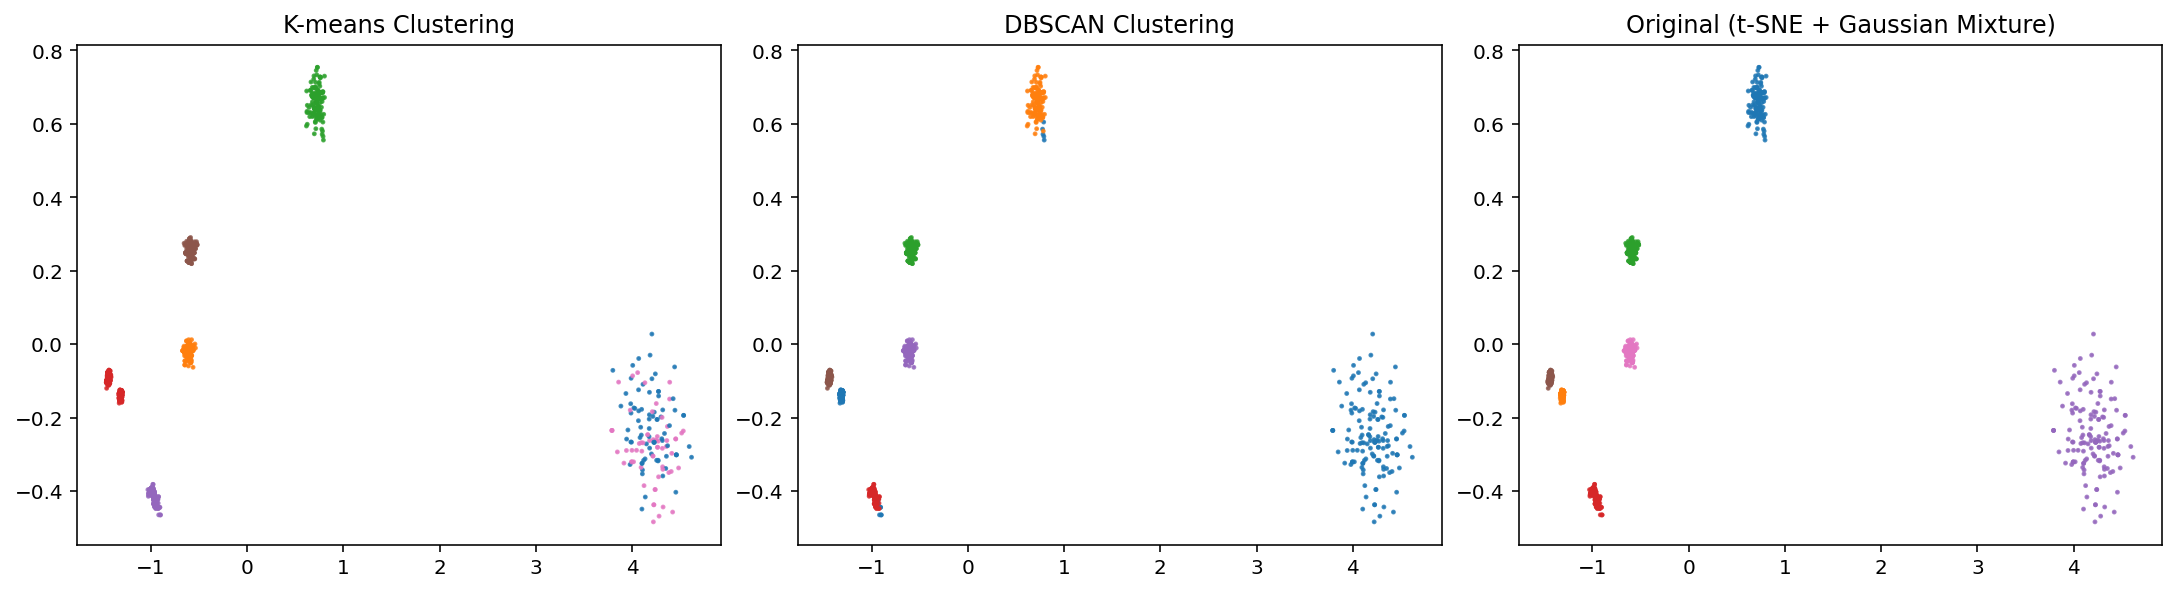

ARI (K-means): 0.8082711605726959
ARI (DBSCAN): 0.9739277863940172


In [524]:
from sklearn.cluster import KMeans, DBSCAN

# Dimensionality Reduction (Optional)
model_lowd = PCA(n_components=8)
low_dimension_imgs = model_lowd.fit_transform(all_images)

# K-means Clustering
kmeans = KMeans(n_clusters=7, random_state=0)  # Assuming 7 clusters
data_classes_kmeans = kmeans.fit_predict(low_dimension_imgs)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.1, min_samples=10)  # You'll need to tune eps and min_samples
data_classes_dbscan = dbscan.fit_predict(low_dimension_imgs)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=144, constrained_layout=True)

# K-means
axes[0].scatter(low_dimension_imgs[:, 0], low_dimension_imgs[:, 1],
                c=mpl.cm.tab10(data_classes_kmeans), s=2, alpha=0.8)
axes[0].set_title("K-means Clustering")

# DBSCAN
axes[1].scatter(low_dimension_imgs[:, 0], low_dimension_imgs[:, 1],
                c=mpl.cm.tab10(data_classes_dbscan), s=2, alpha=0.8)
axes[1].set_title("DBSCAN Clustering")

# Original (Gaussian Mixture)
axes[2].scatter(low_dimension_imgs[:, 0], low_dimension_imgs[:, 1],
                c=mpl.cm.tab10(data_classes_gmm), s=2, alpha=0.8)
axes[2].set_title("Original (t-SNE + Gaussian Mixture)")

plt.show()

# Evaluation (Adjusted Rand Index)
ari_kmeans = adjusted_rand_score(lattice_num_, data_classes_kmeans)
ari_dbscan = adjusted_rand_score(lattice_num_, data_classes_dbscan)

print("ARI (K-means):", ari_kmeans)
print("ARI (DBSCAN):", ari_dbscan)

- Try different values for `DBSCAN(eps=0.2, min_samples=10)`
- Is K-means a deterministic method ? Change the `random_state` variable